# Adjacent Nodes Trajectories in Temporal Bipartite Graphs and Hypergraphs
## Moses Boudourides

[<span style="color:green">0. Imports and Functions</span>](#0)

[<span style="color:green">1. Randomly Generated Temporal Bipartite Graphs (of Groups vs. Persons)</span>](#1)

[<span style="color:green">1a. Plots of Temporal Bipartite Graphs</span>](#1a)

[<span style="color:green">2. Temporal Bipartite Graphs as Temporal Hypergraphs</span>](#2)

[<span style="color:green">2a. Temporal Hyperedges being the First Bipartition (Groups)</span>](#2a)

[<span style="color:green">2b. Temporal Hyperedges being the Second Bipartition (Persons)</span>](#2b)

[<span style="color:green">3. Adjacent Nodes Trajectories of Temporal Bipartite Graphs</span>](#3)

[<span style="color:green">3a. Temporal Hyperedges being the First Bipartition (Groups)</span>](#3a)

[<span style="color:green">3b. Temporal Hyperedges being the Second Bipartition (Persons)</span>](#3b)

<a id='0'></a>
### <span style="color:green">0. Imports and Functions</span>

In [1]:
# from utils import *
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import random
import math
import itertools as it
import numpy as np
import scipy as sp
import pygraphviz, graphviz
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 
from hnxwidget import HypernetxWidget
import hypernetx as hnx
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from pymnet import *
import teneto
from teneto import TemporalNetwork
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/moses/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
def generate_random_bipartite_graph(n1,n2,m):
    k=max([n1,n2])
    V1=[]
    for n in range(k):
        if n<9:
            V1.append("p0"+str(n+1))
        else:
            V1.append("p"+str(n+1))
    V2=[]
    for n in range(k):
        if n<9:
            V2.append("g0"+str(n+1))
        else:
            V2.append("g"+str(n+1))
    V1k=V1[:n1]
    V2k=V2[:n2]
    V12=list(it.product(V1k, V2k))
    while True:
        E=random.sample(V12,m)
        e0=[e[0] for e in E]
        e1=[e[1] for e in E]
        if sorted(set(e0))==sorted(V1k) and sorted(set(e1))==sorted(V2k):
            break
    H=nx.Graph()
    H.add_edges_from(E)
    return H 

def adjust4(nlist,graphs):
    k1=max(nlist[0:-1:2]) 
    k2=max(nlist[1:-1:2]) 
    for i in range(len(graphs)):
        V1=[]
        for n in range(k1):
            if n<9:
                V1.append("p0"+str(n+1))
            else:
                V1.append("p"+str(n+1))
        V2=[]
        for n in range(k2):
            if n<9:
                V2.append("g0"+str(n+1))
            else:
                V2.append("g"+str(n+1))
    agraphs=[]
    for i in range(len(graphs)):
        if i%2==0:
            graphs[i].add_nodes_from(V1)
            graphs[i].add_edges_from([(x,x) for x in V1+V2 if x not in graphs[i].nodes()])
            agraphs.append(graphs[i])
        else:
            graphs[i].add_nodes_from(V2)
            graphs[i].add_edges_from([(x,x) for x in V1+V2 if x not in graphs[i].nodes()])
            agraphs.append(graphs[i])
    return agraphs,V1,V2

def plot4(groups,nlist,graphs,pos,times,figsize):
    # len(graphs)=len(times) !
    N=len(graphs)
    graphs,V1,V2=adjust4(nlist,graphs)
    nrows=math.ceil(N/2)
    ncols=2
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0, wspace=0)
    for i in range(1,N+1):
        ax = plt.subplot(nrows, ncols, i)
        name=times[i-1] 
        nodes1 = nx.draw_networkx_nodes(graphs[i-1], pos=pos, nodelist=V1, node_shape='o', node_color="lime", alpha=0.4, ax=ax) 
        nodes2 = nx.draw_networkx_nodes(graphs[i-1], pos=pos, nodelist=V2, node_shape='s', node_color="lightcoral", alpha=0.4, ax=ax) 
        nx.draw_networkx_edges(graphs[i-1], pos=pos, edge_color="b", alpha=0.6, ax=ax) 
        nx.draw_networkx_labels(graphs[i-1], pos=pos, ax=ax)
        ax.set_title(name,fontsize=15,y=0.93);  #
        plt.axis('off');
        plt.margins(x=0.1, y=0.1)
        
def vert2_layout(X,Y,h): 
    pos={}
    L=max([len(X),len(Y)])
    for i,x in list(enumerate(X)):
        if len(X)>1:
            pos[x]=(i*L/(len(X)-1),0) 
        else:
            pos[x]=(L/2,0) 
    for j,y in list(enumerate(Y)):
        if len(Y)>1:
            pos[y]=(j*L/(len(Y)-1),h) 
        else:
            pos[y]=(L/2,h) 
    return pos

def graphMerge(graphs):
    t=[]
    mapping_d={}
    for i in range(len(graphs)):
        mapping={}
        for n in graphs[i].nodes():
            mapping[n]=n+"(t"+str(i+1)+")"
        mapping_d[i]=mapping
    for i in range(len(graphs)):
        H = nx.relabel_nodes(graphs[i], mapping_d[i])
        t.append(H)
    g=nx.Graph()
    V=[]
    E=[]
    for s in t:
        for n in list(s.nodes()):
            V.append(n)
    for s in t:
        for e in list(s.edges()):
            E.append(e)
    g.add_nodes_from(V)
    g.add_edges_from(E)
    return g

def graphMergeVerticalEdges(graphs,V1,V2):
    g=graphMerge(graphs)
    V1_d={}
    V2_d={}
    for v1 in V1:
        t=[]
        for n in sorted(g.nodes):
            if n[:3]==v1:
                t.append(n)
        V1_d[v1]=t
    for v2 in V2:
        t=[]
        for n in sorted(g.nodes):
            if n[:3]==v2:
                t.append(n)
        V2_d[v2]=t
    addE=[]
    for k,v in V1_d.items():
        for i in range(len(v)-1):
            addE.append((v[i],v[i+1]))
    for k,v in V2_d.items():
        for i in range(len(v)-1):
            addE.append((v[i],v[i+1]))
    g.add_edges_from(addE)
    realE=[e for e in list(g.edges()) if e not in addE]
    return g,addE,realE

def temporalPos(nlist,graphs,times,seg,dis,h,H):
    graphs,V1,V2=adjust4(nlist,graphs)
    g=graphMerge(graphs)
    pos=vert2_layout(V1,V2,h)
    for k,v in pos.items():
        if k in V2:
            pos[k]=(pos[k][0]+seg,pos[k][1])
    poss={}
    for i in range(len(times)):
        for n in g.nodes():
            m=n[:3]
            s=int(n[3:].replace("(t","").replace(")",""))
            if i==s-1:
                poss[n]=(pos[m][0],pos[m][1]+H*i)
    for i in range(1,len(times)-1):
        for n in g.nodes():
            m=n[:3]
            s=int(n[3:].replace("(t","").replace(")",""))
            if i==s-1:
                if i%2==1:
                    poss[n]=(poss[n][0]+i*dis,poss[n][1])
                else:
                    poss[n]=(poss[n][0]-(i-1)*dis,poss[n][1])
    return poss 

def temporalPlot(nlist,graphs,times,seg,dis,h,H,figsize,colors):
    #len(colors)=len(times)=len(graphs) 
    graphs,V1,V2=adjust4(nlist,graphs)
    g,addE,realE=graphMergeVerticalEdges(graphs,V1,V2)
    pos=temporalPos(nlist,graphs,times,seg,dis,h,H)
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=figsize)
    nx.draw_networkx_nodes(g, pos=pos, nodelist=[n for n in g.nodes() if n[:3] in V1], node_shape='o', node_color="lime", alpha=0.4, ax=ax)
    nx.draw_networkx_nodes(g, pos=pos, nodelist=[n for n in g.nodes() if n[:3] in V2], node_shape='s', node_color="lightcoral", alpha=0.4, ax=ax)
    nx.draw_networkx_edges(g, pos=pos, edgelist=addE, style='--', edge_color="b", alpha=0.25, ax=ax)
    nx.draw_networkx_edges(g, pos=pos, edgelist=realE, edge_color="b", alpha=0.6, ax=ax)
    nx.draw_networkx_labels(g, pos=pos, ax=ax)
    mp0=sorted(V1)[0]+"(t1)"
    Mp0=sorted(V1)[-1]+"(t1)"
    Mg0=sorted(V2)[-1]+"(t1)"
    mg0=sorted(V2)[0]+"(t1)"
    x1=0
    x2=0
    x3=0
    x4=0
    y1=0
    y2=0
    y3=0
    y4=0
    for k,v in pos.items():
        if k==mp0:
            x1+=v[0]-seg-0.1
            y1+=v[1]-seg/3 
    for k,v in pos.items():
        if k==Mp0:
            x2+=v[0]-seg+0.6
            y2+=v[1]-seg/3 
    for k,v in pos.items():
        if k==Mg0:
            x3+=v[0]-seg+0.6
            y3+=v[1]+seg/3 
    for k,v in pos.items():
        if k==mg0:
            x4+=v[0]-seg-0.1
            y4+=v[1]+seg/3 
    hh=y3-y2
    b=1
    for i in range(len(times)):
        x = [x1,x2,x3,x4] 
        y = [y1+i*H*b,y2+i*H*b,y3+i*H*b,y4+i*H*b]
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), color=colors[i], alpha=0.3))
        ax.text(x[1]+0.3, i*H+hh/3, times[i], ha='center') 
    ax.set_axis_off() 
    plt.show()
    
def pymnet_stuff(graphs,times):
    # graphs and times are two lists of the same length
    # all graphs involve all nodes!!!!!
    # every graph is partitioned in "persons" and "groups"
    QQ=[]
    Z=zip(graphs,times)
    for graph,time in Z:
        Q=[]
        for e in graph.edges:
            q=[]
            q.append(e[0])
            q.append(e[1])
            q.append(time)
            Q.append(q)
        Q=[tuple(q) for q in Q]
        QQ.append(Q)
    net=MultiplexNetwork(couplings="categorical")
    for Q in QQ:
        for z in Q:
            net[z]=1
    return net

def teneto_stuff(graphs,times):
    # graphs and times are two lists of the same length
    # all graphs involve all nodes!!!!!
    # every graph is partitioned in "persons" and "groups"
    G=[] 
    for i in range((len(graphs[0]))):
        L=[]
        for j in range(len(graphs)):
            Ai=nx.adjacency_matrix(graphs[j], nodelist=sorted(graphs[j].nodes)).todense()
            L.append(Ai[:,i])
        L=np.array(L)
        J=np.zeros((len(graphs[0].nodes),len(times)))
        for k in range(len(times)):
            J[:,k]=L[k].T
        G.append(J)
    G=np.array(G)
    return G

def hypergraphs(mode,nlist,times,graphs):
    graphs,V1,V2=adjust4(nlist,graphs)
    group_hg={}
    for y in mode:
        t2p_d={}
        for i in range(len(times)):
            neighs=list(graphs[i].neighbors(y))
            if len(neighs)>0:
                t2p_d[times[i]]=neighs
        group_hg[y]=t2p_d
    return group_hg

def hypergraphs_plot(mode,modenames_d,nlist,times,graphs,figsize):
    graphs,V1,V2=adjust4(nlist,graphs)
    modestr=""
    if mode==V1:
        modestr+="V1"
    if mode==V2:
        modestr+="V2"
    hg=hypergraphs(mode,nlist,times,graphs)
    if len(mode)%3==0:
        nrows=int(len(mode)/3)
    else:
        nrows=int(len(mode)/3)+1
    ncols=3
    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0)
    plt.suptitle("Hypergraphs of "+modenames_d[modestr],fontweight="bold",fontsize=20, y=0.93)
    for i, group in enumerate(mode):
        hgg=hg[group]
        ax = plt.subplot(nrows, ncols, i + 1)
        hnx.draw(hnx.Hypergraph(hgg)) 
        ax.set_title(group,fontweight="bold",fontsize=14,y=0.93)
        
def group_activation(nlist,times,graphs):
    graphs,V1,V2=adjust4(nlist,graphs)
    etimes=list(range(len(times)))
    d={}
    for group in V2:
        t=[]
        for i,graph in enumerate(graphs):
            if len(list(graph.neighbors(group)))>0:
                t.append((times[i],1))
            else:
                t.append((times[i],0))
        d[group]=t
    return d

def person_activation(nlist,times,graphs):
    graphs,V1,V2=adjust4(nlist,graphs)
    etimes=list(range(len(times)))
    d={}
    for person in V1:
        t=[]
        for i,graph in enumerate(graphs):
            if len(list(graph.neighbors(person)))>0:
                t.append((times[i],1))
            else:
                t.append((times[i],0))
        d[person]=t
    return d

def time_hyperedges_intersections(mode,nlist,times,graphs,V1,V2):
    atimes_d=actimes(mode,nlist,times,graphs,V1,V2)
    dd={}
    hg=hypergraphs(mode,nlist,times,graphs)
    for k,v in hg.items():
        ak=atimes_d[k]
        if len(ak)>1:
            d={}
            for j in list(it.combinations(ak,2)):
                ints=sorted(set(v[j[0]]).intersection(set(v[j[1]])))
                dif1=sorted(set(v[j[0]])-set(v[j[1]]))
                dif2=sorted(set(v[j[1]])-set(v[j[0]]))
                d[j]=(ints,dif1,dif2)
            dd[k]=d
    return dd

def actimes(mode,nlist,times,graphs,V1,V2):
    hg=hypergraphs(mode,nlist,times,graphs)
    if mode==V1:
        da=person_activation(nlist,times,graphs)
    if mode==V2:
        da=group_activation(nlist,times,graphs)
    d={}
    for group in mode:
        for k,v in da.items():
            if k==group:
                t=[]
                for vv in v:
                    if vv[1]==1:
                        t.append(vv[0])
        d[group]=sorted(t)
    return d

def Trajectories(mode,nlist,times,graphs,V1,V2): 
    if mode==V1:
        da=person_activation(nlist,times,graphs)
    if mode==V2:
        da=group_activation(nlist,times,graphs)
    tgraphs_d={}
    for group in mode: #groups:
        atimes=[]
        for k,v in da.items():
            if k==group:
                for vv in v:
                    if vv[1]==1:
                        atimes.append(vv[0])
        if len(atimes)>1:
            eds=[]
            for j in list(it.combinations(atimes,2)):
                s0=int(j[0].replace("t",""))-1
                s1=int(j[1].replace("t",""))-1
                neighs0=[m+"("+str(j[0])+")" for m in list(graphs[s0].neighbors(group))]
                neighs1=[m+"("+str(j[1])+")" for m in list(graphs[s1].neighbors(group))]
                pairs=[[l,n] for l in neighs0 for n in neighs1]
                for pair in pairs:
                    eds.append(pair)
            g=nx.DiGraph()
            g.add_edges_from(eds)
            tgraphs_d[group]=g 
    return tgraphs_d

def hg_Trajectories(mode,nlist,times,graphs,V1,V2): #groups,
    if mode==V1:
        da=person_activation(nlist,times,graphs)
    if mode==V2:
        da=group_activation(nlist,times,graphs)
    dd=time_hyperedges_intersections(mode,nlist,times,graphs,V1,V2)
    htgraphs_d={}
    for k,v in dd.items():
        eds=[]
        for vv in list(v.items()):
            h1=vv[1][1]+vv[1][0]
            h2=vv[1][2]+vv[1][0]
            for p in h1:
                p=p+"("+vv[0][0]+")"
                for q in h2:
                    q=q+"("+vv[0][1]+")"
                    if (p,q) not in eds:
                        eds.append((p,q))
        g=nx.DiGraph()
        g.add_edges_from(eds)
        htgraphs_d[k]=g
    return htgraphs_d

def hg_trajectories_plot(mode,modenames_d,nlist,times,graphs,V1,V2,figsize):
    modestr=""
    if mode==V1:
        modestr+="V1"
    if mode==V2:
        modestr+="V2"
    rmodestr=""
    if mode==V1:
        rmodestr+="V2"
    if mode==V2:
        rmodestr+="V1"
    htgraphs_d=hg_Trajectories(mode,nlist,times,graphs,V1,V2) 
    if len(mode)%3==0:
        nrows=int(len(mode)/3)
    else:
        nrows=int(len(mode)/3)+1
    ncols=3
    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0)
    ttt="Adjacent Nodes Trajectories of %s over %s" %(modenames_d[modestr],modenames_d[rmodestr])
    plt.suptitle(ttt,fontweight="bold",fontsize=20, y=0.93)
    for i, group in enumerate(mode):
        if group in htgraphs_d.keys():
            tg=htgraphs_d[group]
            ax = plt.subplot(nrows, ncols, i + 1)
            layers_d={}
            posg={}
            for t in times:
                nt=sorted([n for n in tg.nodes() if t in n])
                if len(nt)>0:
                    layers_d[t]=nt
            sl_d={int(k.replace("t",""))-1:len(v) for k,v in layers_d.items()}
            mw=max(list(sl_d.values()))
            for n in tg.nodes():
                h=int(n[4:].replace("t","").replace(")",""))-1
                for k,v in layers_d.items():
                    w=(mw-len(v))/2
                    for kk,vv in sl_d.items():
                        if kk==h:
                            for j,l in enumerate(v):
                                if n==l:
                                    posg[n]=(w+j,h)
            if mode==V2:
                nodes = nx.draw_networkx_nodes(tg, pos=posg, node_shape='o', node_color="lime", alpha=0.3,ax=ax)
            if mode==V1:
                nodes = nx.draw_networkx_nodes(tg, pos=posg, node_shape='s', node_color="lightcoral", alpha=0.3,ax=ax)
            nx.draw_networkx_edges(tg, pos=posg, arrowsize=20,edge_color="r", alpha=0.6,ax=ax)
            nx.draw_networkx_labels(tg, pos=posg,ax=ax);
            plt.axis('off');
            plt.title(group,fontweight="bold",fontsize=14,y=0.93);
            plt.margins(x=0.1, y=0.1)       
            ax.set_title(group,fontweight="bold",fontsize=14,y=0.93)
            
def plot_all_trajectories_graph(mode,nlist,times,graphs,V1,V2,h,title,figsize,wtype): 
    graph=all_trajectories_graph(mode,nlist,times,graphs,V1,V2)
    edge_width=[graph[u][v]['weight'] for u,v in graph.edges()]
    edge_labels = nx.get_edge_attributes(graph, "weight")
    X=[n for n in graph.nodes() if n[:n.index("(")] in V1]
    Y=[n for n in graph.nodes() if n[:n.index("(")] in V2]
    layers_d={}
    posg={}
    for t in times:
        nt=sorted([n for n in graph.nodes() if t in n])
        if len(nt)>0:
            layers_d[t]=nt
    sl_d={int(k.replace("t",""))-1:len(v) for k,v in layers_d.items()}
    mw=max(list(sl_d.values()))
    for n in graph.nodes():
        h=int(n[4:].replace("t","").replace(")",""))-1
        for k,v in layers_d.items():
            w=(mw-len(v))/2
            for kk,vv in sl_d.items():
                if kk==h:
                    for j,l in enumerate(v):
                        if n==l:
                            posg[n]=(w+j,h)
    plt.figure(figsize=figsize)
    nodes1 = nx.draw_networkx_nodes(graph, pos=posg, nodelist=X, node_shape='o', node_color="lime", alpha=0.4)
    nodes2 = nx.draw_networkx_nodes(graph, pos=posg, nodelist=Y, node_shape='s', node_color="lightcoral", alpha=0.4)
    if wtype=="width":
        nx.draw_networkx_edges(graph, pos=posg, width=edge_width, edge_color="r", alpha=0.6)
    if wtype=="label":
        nx.draw_networkx_edges(graph, pos=posg, width=1, edge_color="r", alpha=0.6)
        nx.draw_networkx_edge_labels(graph, posg, edge_labels,label_pos=.34)
    nx.draw_networkx_labels(graph, pos=posg)
    plt.title(title) 
    plt.axis('off');
    
def all_trajectories_graph(mode,nlist,times,graphs,V1,V2):
    tgraphs_d=Trajectories(mode,nlist,times,graphs,V1,V2)
    meds=[]
    for g in list(tgraphs_d.values()):
        for e in g.edges():
            meds.append((e[0],e[1]))
    weds=[]
    for k,v in Counter(meds).items():
        weds.append((k[0],k[1],v))
    tg=nx.DiGraph()
    tg.add_weighted_edges_from(weds)
    return tg

def plot_all_trajectories_graph(mode,nlist,times,graphs,V1,V2,h,title,figsize,wtype): 
    graph=all_trajectories_graph(mode,nlist,times,graphs,V1,V2)
    edge_width=[graph[u][v]['weight'] for u,v in graph.edges()]
    edge_labels = nx.get_edge_attributes(graph, "weight")
    X=[n for n in graph.nodes() if n[:n.index("(")] in V1]
    Y=[n for n in graph.nodes() if n[:n.index("(")] in V2]
    layers_d={}
    posg={}
    for t in times:
        nt=sorted([n for n in graph.nodes() if t in n])
        if len(nt)>0:
            layers_d[t]=nt
    sl_d={int(k.replace("t",""))-1:len(v) for k,v in layers_d.items()}
    mw=max(list(sl_d.values()))
    for n in graph.nodes():
        h=int(n[4:].replace("t","").replace(")",""))-1
        for k,v in layers_d.items():
            w=(mw-len(v))/2
            for kk,vv in sl_d.items():
                if kk==h:
                    for j,l in enumerate(v):
                        if n==l:
                            posg[n]=(w+j,h)
    plt.figure(figsize=figsize)
    nodes1 = nx.draw_networkx_nodes(graph, pos=posg, nodelist=X, node_shape='o', node_color="lime", alpha=0.4)
    nodes2 = nx.draw_networkx_nodes(graph, pos=posg, nodelist=Y, node_shape='s', node_color="lightcoral", alpha=0.4)
    if wtype=="width":
        nx.draw_networkx_edges(graph, pos=posg, width=edge_width, edge_color="r", alpha=0.6)
    if wtype=="label":
        nx.draw_networkx_edges(graph, pos=posg, width=1, edge_color="r", alpha=0.6)
        nx.draw_networkx_edge_labels(graph, posg, edge_labels,label_pos=.34)
    nx.draw_networkx_labels(graph, pos=posg)
    plt.title(title) 
    plt.axis('off');

def pos_oblique(pos,V2,H):
    d={}
    for k,v in pos.items():
        if k in V2:
            d[k]=[pos[k][0]+H,pos[k][1]]
        else:
            d[k]=pos[k]
    return d

def temporalPlotWithTrajectories(mode,nlist,graphs,times,V1,V2,seg,dis,h,H,figsize,colors,loc):
    #len(colors)=len(times)=len(graphs) 
    graphs,V1,V2=adjust4(nlist,graphs)
    g,addE,realE,trajE=graphMergeVerticalEdgesWithTrajectories(mode,nlist,times,graphs,V1,V2,loc)
    pos=temporalPos(nlist,graphs,times,seg,dis,h,H)
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=figsize)
    nx.draw_networkx_nodes(g, pos=pos, nodelist=[n for n in g.nodes() if n[:3] in V1], node_shape='o', node_color="lime", alpha=0.4, ax=ax)
    nx.draw_networkx_nodes(g, pos=pos, nodelist=[n for n in g.nodes() if n[:3] in V2], node_shape='s', node_color="lightcoral", alpha=0.4, ax=ax)
    nx.draw_networkx_edges(g, pos=pos, edgelist=addE, style='--', edge_color="b", alpha=0.25, ax=ax)
    nx.draw_networkx_edges(g, pos=pos, edgelist=realE, edge_color="b", alpha=0.6, ax=ax)
    nx.draw_networkx_labels(g, pos=pos, ax=ax)
    mp0=sorted(V1)[0]+"(t1)"
    Mp0=sorted(V1)[-1]+"(t1)"
    Mg0=sorted(V2)[-1]+"(t1)"
    mg0=sorted(V2)[0]+"(t1)"
    x1=0
    x2=0
    x3=0
    x4=0
    y1=0
    y2=0
    y3=0
    y4=0
    for k,v in pos.items():
        if k==mp0:
            x1+=v[0]-seg-0.1
            y1+=v[1]-seg/3 
    for k,v in pos.items():
        if k==Mp0:
            x2+=v[0]-seg+0.6
            y2+=v[1]-seg/3 
    for k,v in pos.items():
        if k==Mg0:
            x3+=v[0]-seg+0.6
            y3+=v[1]+seg/3 
    for k,v in pos.items():
        if k==mg0:
            x4+=v[0]-seg-0.1
            y4+=v[1]+seg/3 
    hh=y3-y2
    b=1
    for i in range(len(times)):
        x = [x1,x2,x3,x4] 
        y = [y1+i*H*b,y2+i*H*b,y3+i*H*b,y4+i*H*b]
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), color=colors[i], alpha=0.3))

        ax.text(x[1]+0.3, i*H+hh/3, "t"+str(i+1), ha='center')
    for tr in trajE:
        x1=pos[tr[0]][0]
        y1=pos[tr[0]][1]
        x2=pos[tr[1]][0]
        y2=pos[tr[1]][1]
        plt.arrow(x1,y1, x2-x1,y2-y1, color='red', head_length = 0.05, head_width = 0.05, length_includes_head = True)
    ax.set_axis_off() 
    plt.show()
    
def groupTrajectories(groups,nlist,times,graphs):
    da=group_activation(nlist,times,graphs)
    tgraphs_d={}
    for group in groups:
        atimes=[]
        for k,v in da.items():
            if k==group:
                for vv in v:
                    if vv[1]==1:
                        atimes.append(vv[0])
        if len(atimes)>1:
            eds=[]
            for j in list(it.combinations(atimes,2)):
                s0=int(j[0].replace("t",""))-1
                s1=int(j[1].replace("t",""))-1
                neighs0=[m+"("+str(j[0])+")" for m in list(graphs[s0].neighbors(group))]
                neighs1=[m+"("+str(j[1])+")" for m in list(graphs[s1].neighbors(group))]
                pairs=[[l,n] for l in neighs0 for n in neighs1]
                for pair in pairs:
                    eds.append(pair)
            g=nx.DiGraph()
            g.add_edges_from(eds)
            tgraphs_d[group]=g #.edges)
    return tgraphs_d

def graphMergeVerticalEdgesWithTrajectories(mode,nlist,times,graphs,V1,V2,loc):
    # graphs,V1,V2=adjust4(nlist,graphs)
    g=graphMerge(graphs)
    tgraphs_d=Trajectories(mode,nlist,times,graphs,V1,V2)
    V1_d={}
    V2_d={}
    for v1 in V1:
        t=[]
        for n in sorted(g.nodes):
            if n[:3]==v1:
                t.append(n)
        V1_d[v1]=t
    for v2 in V2:
        t=[]
        for n in sorted(g.nodes):
            if n[:3]==v2:
                t.append(n)
        V2_d[v2]=t
    addE=[]
    for k,v in V1_d.items():
        for i in range(len(v)-1):
            addE.append((v[i],v[i+1]))
    for k,v in V2_d.items():
        for i in range(len(v)-1):
            addE.append((v[i],v[i+1]))
    g.add_edges_from(addE)
    realE=[e for e in list(g.edges()) if e not in addE]
    trajE=[]
    for k,v in tgraphs_d.items():
        if k in loc:
            for e in v.edges():
                trajE.append(e)
    return g,addE,realE,trajE

<a id='1'></a>
### <span style="color:green">1. Randomly Generated Temporal Bipartite Graphs (of Groups vs. Persons)</span>

In [3]:
# ni1 = the number of nodes of the first mode (persons) of the bipartite graph i (Hi)
# ni2 = the number of nodes of the second mode (groups) of the bipartite graph i (Hi)
# mi  = the number of edges of the bipartite graph i (Hi)

n11=2 
n12=3 
m1=4
H1=generate_random_bipartite_graph(n11,n12,m1)
print(len(H1.nodes()),len(H1.edges()))

n21=2
n22=2 
m2=2
H2=generate_random_bipartite_graph(n21,n22,m2)
print(len(H2.nodes()),len(H2.edges()))

n31=2
n32=3
m3=4
H3=generate_random_bipartite_graph(n31,n32,m3)
print(len(H3.nodes()),len(H3.edges()))

n41=4
n42=3 
m4=4
H4=generate_random_bipartite_graph(n41,n42,m4)
print(len(H4.nodes()),len(H4.edges()))

# n51=2
# n52=3 #4
# m5=3
# H5=generate_random_bipartite_graph(n51,n52,m5)
# print(len(H5.nodes()),len(H5.edges()))

# n61=4
# n62=3 #4
# m6=4
# H6=generate_random_bipartite_graph(n61,n62,m6)
# print(len(H6.nodes()),len(H6.edges()))

graphs=[H1,H2,H3,H4] #,H5,H6]
times=["t1","t2","t3","t4"] #,"t5","t6"]
times_graphs=tuple(zip(times,graphs))

nlist=[n11,n12,n21,n22,n31,n32,n41,n42] #,n51,n52,n61,n62]

modenames_d={"V1":"Persons","V2":"Groups"}

5 4
4 2
5 4
7 4


<a id='1a'></a>
#### <span style="color:green">1a. Plots of Temporal Bipartite Graphs</span>

#### <span style="color:green">Rectengular Plots</span>

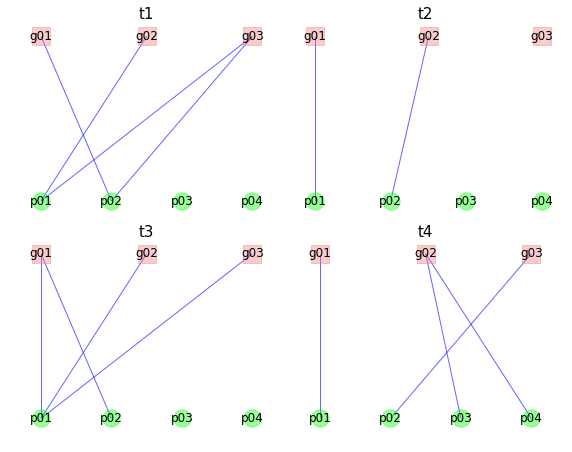

In [4]:
graphs=graphs
graphs,V1,V2=adjust4(nlist,graphs)
groups=V2
pos=vert2_layout(V1,V2,h=1)
for h in graphs:
    h.remove_edges_from([e for e in h.edges() if e[0]==e[1]])
nlist,graphs,pos,times,figsize=nlist,graphs,pos,times,(10,8) 
plot4(groups,nlist,graphs,pos,times,figsize)

#### <span style="color:green">Multilayer Plots</span>

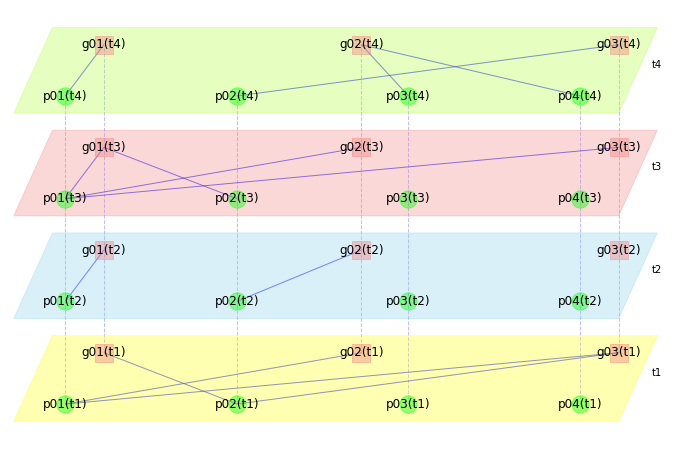

In [5]:
g=graphMerge(graphs)
g,addE,realE=graphMergeVerticalEdges(graphs,V1,V2)

seg=0.3
dis=0 #0.05
h=0.3
H=0.6
pos=temporalPos(nlist,graphs,times,seg,dis,h,H)

figsize=(12,8)
colors=["yellow",'skyblue','lightcoral','greenyellow',"khaki","gainsboro"]
temporalPlot(nlist,graphs,times,seg,dis,h,H,figsize,colors)

#### <span style="color:green">pymnet Plots</span>

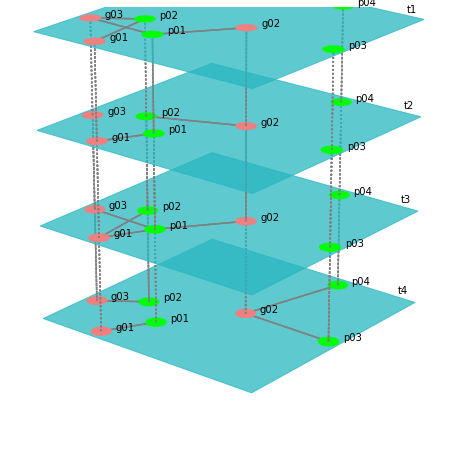

In [6]:
net=pymnet_stuff(graphs,times)

nodeColorDict = {}
for i in net:
    if "g" in i:
        for tt in times:
            nodeColorDict.update(
                {
                    (i, tt): "lightcoral"
                }
            )
    else:
        for tt in times:
            nodeColorDict.update(
                {
                    (i, tt): "lime"
                }
            )

fig = draw(
    net, show = True, #layout = pos, #"spring", 
    figsize = (12,8), defaultLayerLabelLoc = (0.9,1.03), #1.04),
    nodeColorDict = nodeColorDict
    )

#### <span style="color:green">teneto Plots</span>

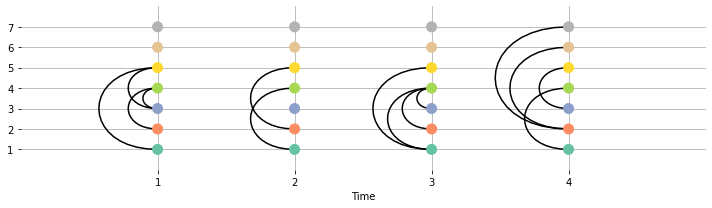

In [7]:
G=teneto_stuff(graphs,times)
# G

fig,ax = plt.subplots(figsize=(10,3))
ax = teneto.plot.slice_plot(G, ax, cmap='Set2') #,netinfo=cfg)
fig.tight_layout()
fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


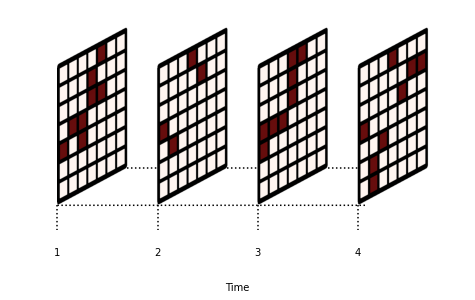

In [8]:
# Create matplotlib figure
fig,ax = plt.subplots(figsize=(10,5))
ax = plt.subplot(1,1,1)
ax = teneto.plot.graphlet_stack_plot(G,ax,q=10,cmap='Reds')

<a id='2'></a>
### <span style="color:green">2. Temporal Bipartite Graphs as Temporal Hypergraphs</span>

<a id='2a'></a>
#### <span style="color:green">2a. Temporal Hyperedges being the First Bipartition (Groups)</span>

In [9]:
mode=V2
group_hg=hypergraphs(mode,nlist,times,graphs) 
group_hg

{'g01': {'t1': ['p02'], 't2': ['p01'], 't3': ['p01', 'p02'], 't4': ['p01']},
 'g02': {'t1': ['p01'], 't2': ['p02'], 't3': ['p01'], 't4': ['p04', 'p03']},
 'g03': {'t1': ['p02', 'p01'], 't3': ['p01'], 't4': ['p02']}}

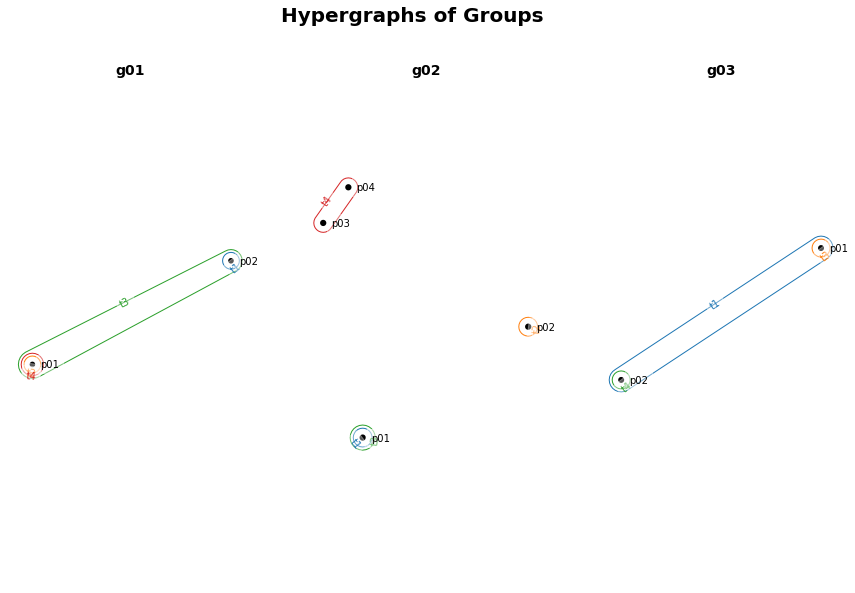

In [10]:
figsize=(15, 10)
hypergraphs_plot(mode,modenames_d,nlist,times,graphs,figsize) #group_

<a id='2b'></a>
#### <span style="color:green">2b. Temporal Hyperedges being the Second Bipartition (Persons)</span>

In [11]:
mode=V1
person_hg=hypergraphs(mode,nlist,times,graphs) #group_
person_hg

{'p01': {'t1': ['g02', 'g03'],
  't2': ['g01'],
  't3': ['g01', 'g03', 'g02'],
  't4': ['g01']},
 'p02': {'t1': ['g03', 'g01'], 't2': ['g02'], 't3': ['g01'], 't4': ['g03']},
 'p03': {'t4': ['g02']},
 'p04': {'t4': ['g02']}}

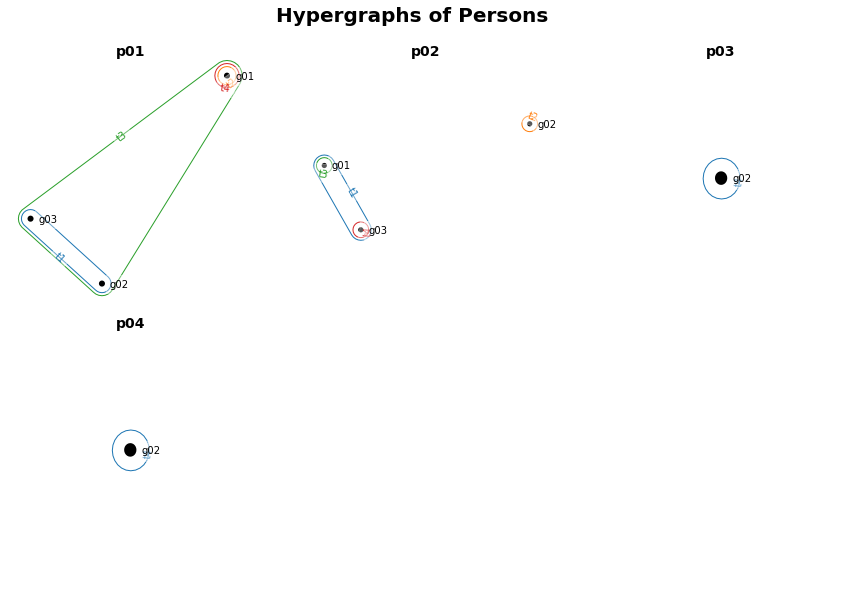

In [12]:
figsize=(15, 10)
hypergraphs_plot(mode,modenames_d,nlist,times,graphs,figsize) #group_

<a id='3'></a>
### <span style="color:green">3. Adjacent Nodes Trajectories of Temporal Hypergraphs</span>

<a id='3a'></a>
#### <span style="color:green">3a. Temporal Hyperedges being the First Bipartition (Groups)</span>

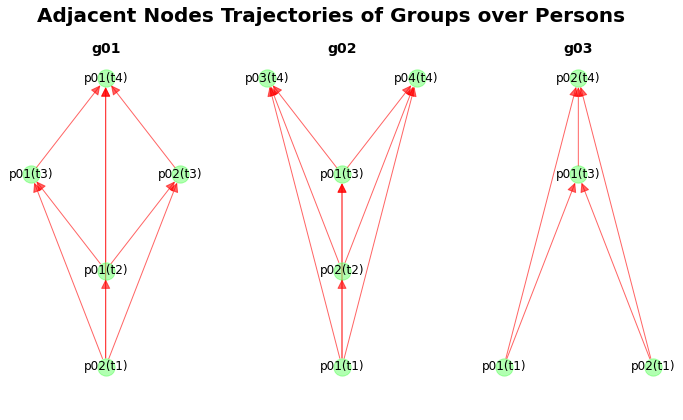

In [13]:
mode=V2
figsize=(12,7)
tgraphs_d=Trajectories(mode,nlist,times,graphs,V1,V2) 
htgraphs_d=hg_Trajectories(mode,nlist,times,graphs,V1,V2) 
hg_trajectories_plot(mode,modenames_d,nlist,times,graphs,V1,V2,figsize)

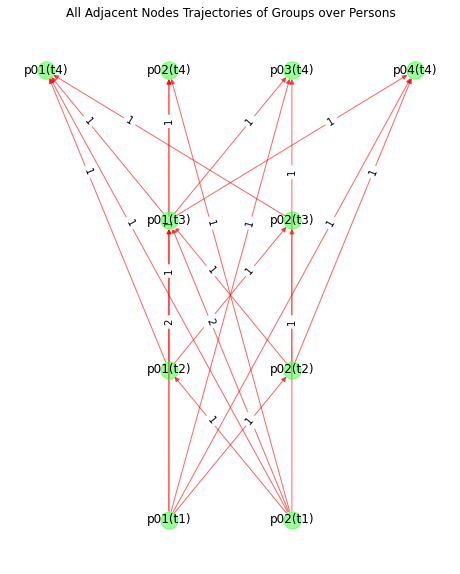

In [14]:
title="All Adjacent Nodes Trajectories of Groups over Persons"
figsize=(8,10)
wtype="label"
plot_all_trajectories_graph(mode,nlist,times,graphs,V1,V2,h,title,figsize,wtype)

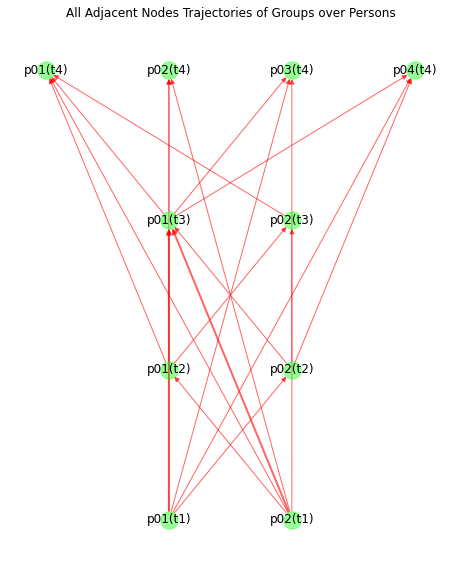

In [15]:
wtype="width"
plot_all_trajectories_graph(mode,nlist,times,graphs,V1,V2,h,title,figsize,wtype)

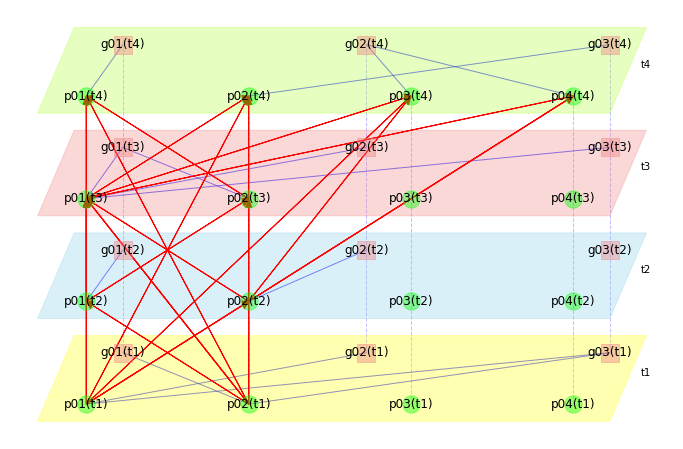

In [16]:
mode=V2
loc=list(tgraphs_d.keys())
seg=0.3
dis=0 #0.05
h=0.3
H=0.6
pos=temporalPos(nlist,graphs,times,seg,dis,h,H)
figsize=(12,8)
# title="All Trajectories of Groups"
temporalPlotWithTrajectories(mode,nlist,graphs,times,V1,V2,seg,dis,h,H,figsize,colors,loc)

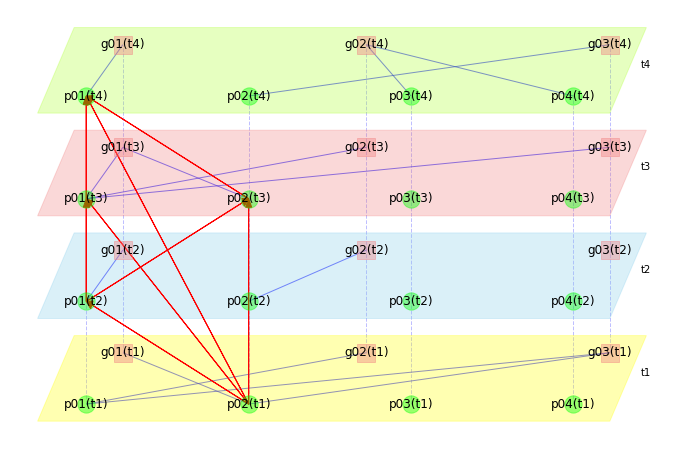

In [17]:
loc=['g01']
temporalPlotWithTrajectories(mode,nlist,graphs,times,V1,V2,seg,dis,h,H,figsize,colors,loc)

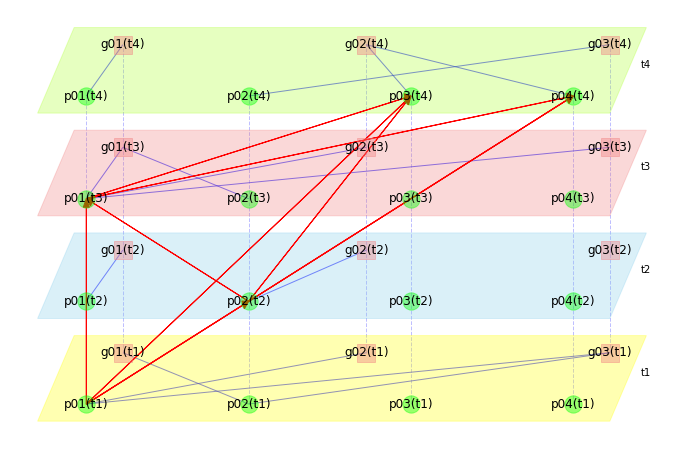

In [18]:
loc=['g02']
temporalPlotWithTrajectories(mode,nlist,graphs,times,V1,V2,seg,dis,h,H,figsize,colors,loc)

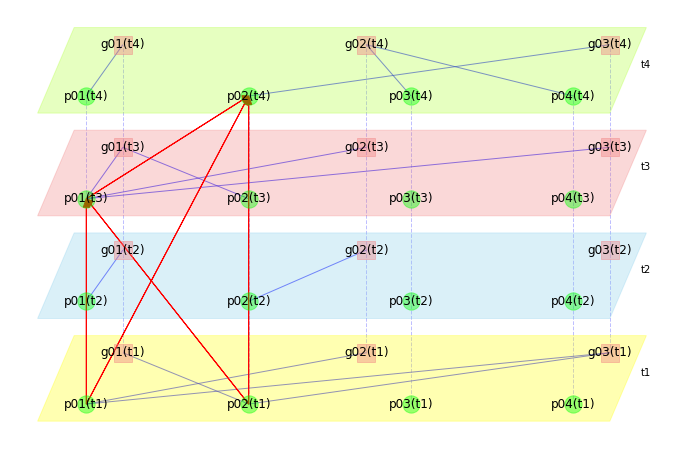

In [19]:
loc=['g03']
temporalPlotWithTrajectories(mode,nlist,graphs,times,V1,V2,seg,dis,h,H,figsize,colors,loc)

<a id='3b'></a>
#### <span style="color:green">3b. Temporal Hyperedges being the Second Bipartition (Persons)</span>

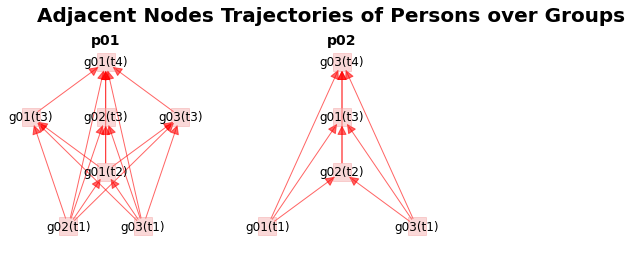

In [20]:
mode=V1
tgraphs_d=Trajectories(mode,nlist,times,graphs,V1,V2)
htgraphs_d=hg_Trajectories(mode,nlist,times,graphs,V1,V2) 
hg_trajectories_plot(mode,modenames_d,nlist,times,graphs,V1,V2,figsize)

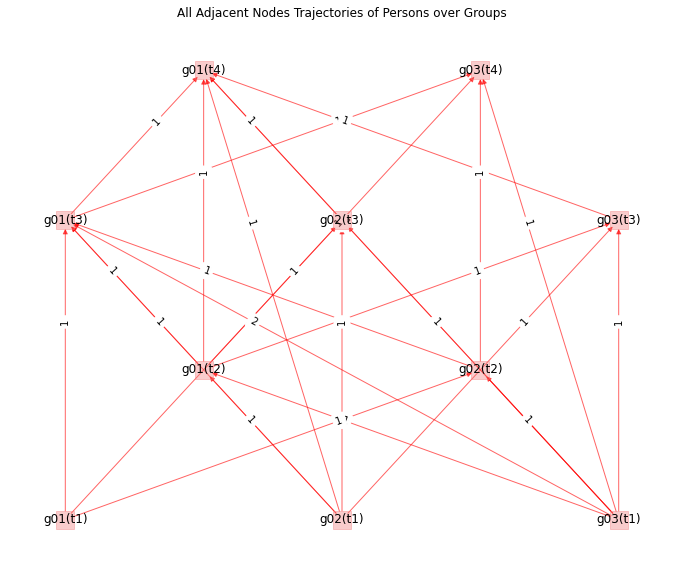

In [21]:
title="All Adjacent Nodes Trajectories of Persons over Groups"
figsize=(12,10)
wtype="label"
plot_all_trajectories_graph(mode,nlist,times,graphs,V1,V2,h,title,figsize,wtype)

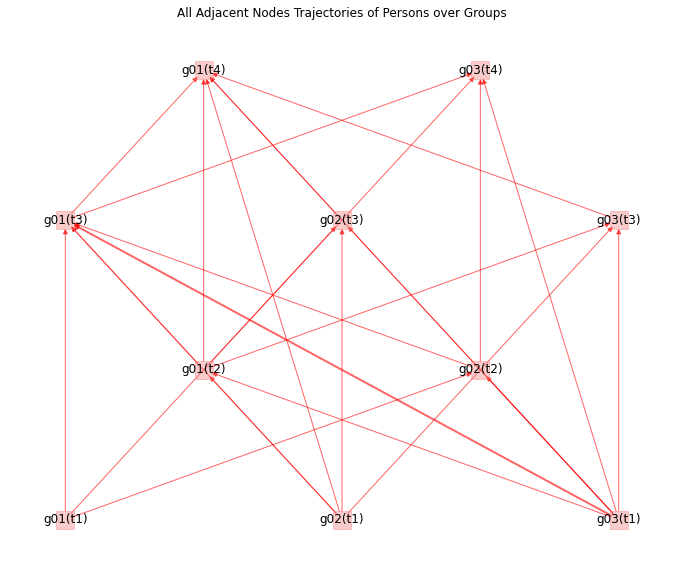

In [22]:
wtype="width"
plot_all_trajectories_graph(mode,nlist,times,graphs,V1,V2,h,title,figsize,wtype)

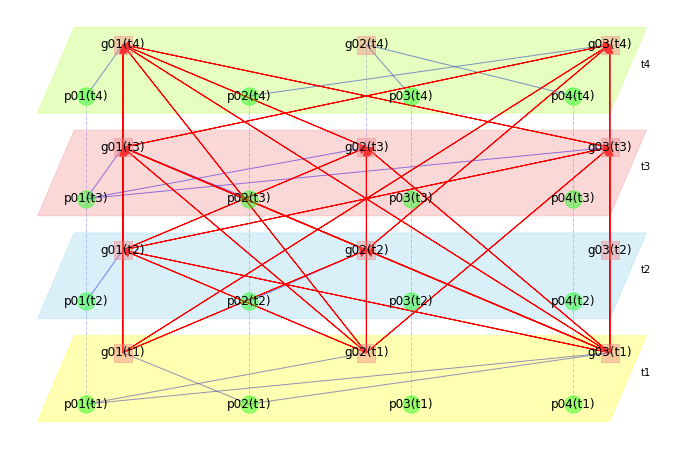

In [23]:
mode=V1
loc=list(tgraphs_d.keys())
seg=0.3
dis=0 #0.05
h=0.3
H=0.6
pos=temporalPos(nlist,graphs,times,seg,dis,h,H)
figsize=(12,8)
# title="All Trajectories of Persons"
temporalPlotWithTrajectories(mode,nlist,graphs,times,V1,V2,seg,dis,h,H,figsize,colors,loc)

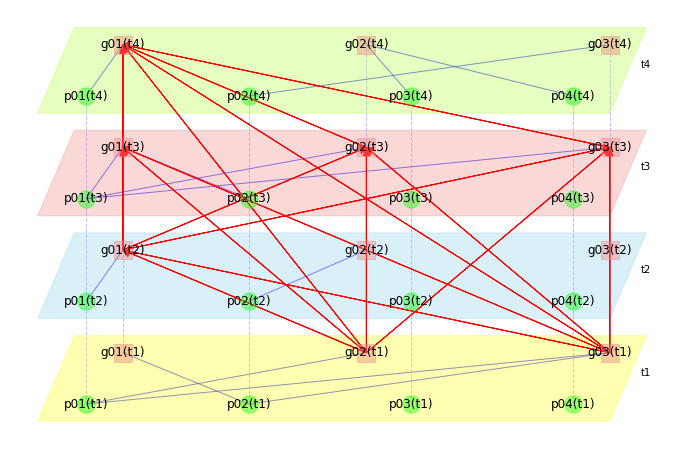

In [24]:
loc=['p01']
temporalPlotWithTrajectories(mode,nlist,graphs,times,V1,V2,seg,dis,h,H,figsize,colors,loc)

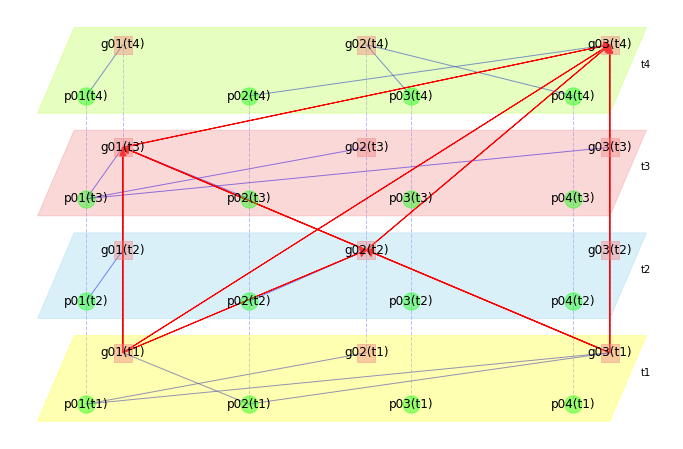

In [25]:
loc=['p02']
temporalPlotWithTrajectories(mode,nlist,graphs,times,V1,V2,seg,dis,h,H,figsize,colors,loc)

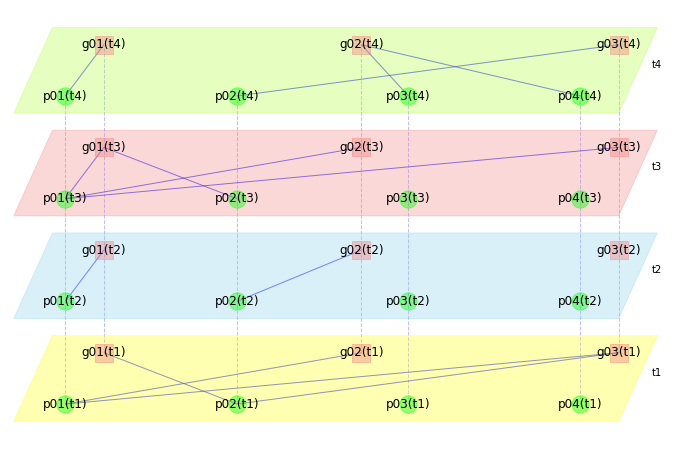

In [26]:
loc=['p03']
temporalPlotWithTrajectories(mode,nlist,graphs,times,V1,V2,seg,dis,h,H,figsize,colors,loc)

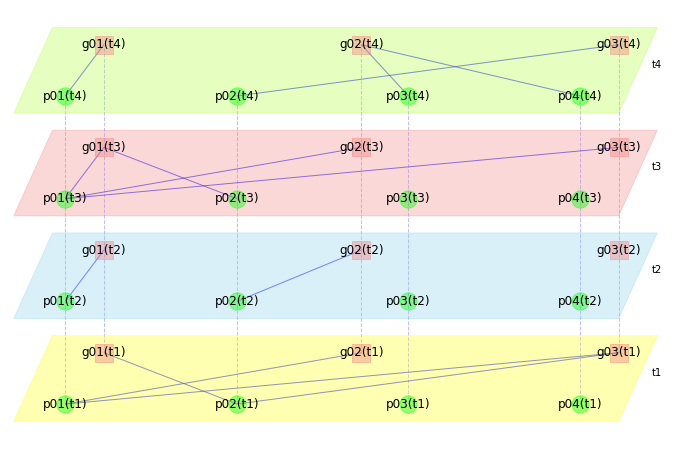

In [27]:
loc=['p04']
temporalPlotWithTrajectories(mode,nlist,graphs,times,V1,V2,seg,dis,h,H,figsize,colors,loc)